In [49]:
import os, json, csv, random
from collections import Counter, defaultdict
from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
dataset_path = "C:/Users/Sagala Rasanjana/Desktop/2025-Y2-S1-MLB-WE1G2-01/Tea Leaf Disease Dataset"
print(repr(dataset_path))
print(os.path.exists(dataset_path))

'C:/Users/Sagala Rasanjana/Desktop/2025-Y2-S1-MLB-WE1G2-01/Tea Leaf Disease Dataset'
True


<Figure size 1000x600 with 0 Axes>

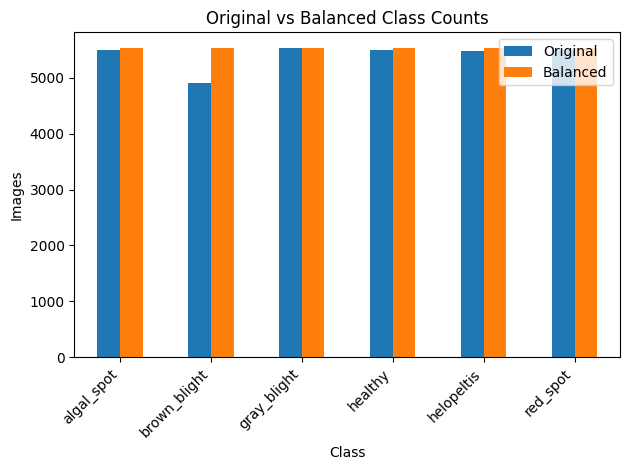

              Original  Balanced
algal_spot        5497      5537
brown_blight      4908      5537
gray_blight       5537      5537
healthy           5492      5537
helopeltis        5482      5537
red_spot          5505      5537


In [51]:
# ----- Helper functions -----
def read_index_from_dir(root_dir):
    # Get all image paths and their class names
    paths, labels = [], []
    for cls in sorted(os.listdir(root_dir)):
        cdir = os.path.join(root_dir, cls)
        if not os.path.isdir(cdir):
            continue
        for f in os.listdir(cdir):
            if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp")):
                paths.append(os.path.join(cdir, f))
                labels.append(cls)
    return paths, labels

def compute_class_weights(labels):
    # Count images and compute weights
    counts = Counter(labels)
    total = sum(counts.values())
    num_classes = len(counts)
    weights = {c: total/(num_classes*cnt) for c, cnt in counts.items()}
    return weights, dict(counts)

def write_json(d, path):
    # Save a dictionary as JSON
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f:
        json.dump(d, f, indent=2)

def make_oversampled_index(paths, labels, out_csv, target_multiplier=1.0):
    # Create a balanced CSV by oversampling small classes
    by_cls = defaultdict(list)
    for p, l in zip(paths, labels):
        by_cls[l].append(p)

    max_count = max(len(v) for v in by_cls.values())
    target = int(max_count * target_multiplier)

    rows = []
    for cls, plist in by_cls.items():
        if len(plist) >= target:
            take = random.sample(plist, target)
        else:
            mult = (target + len(plist) - 1) // len(plist)
            take = (plist * mult)[:target]
        rows.extend([(p, cls) for p in take])

    random.shuffle(rows)
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    with open(out_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["path", "label"])
        w.writerows(rows)

def run_imbalance(train_dir, out_dir):
    # Run full process and save outputs
    paths, labels = read_index_from_dir(train_dir)
    weights, counts = compute_class_weights(labels)
    write_json({"class_weights": weights, "class_counts": counts},
               os.path.join(out_dir, "class_weights.json"))
    make_oversampled_index(paths, labels,
               os.path.join(out_dir, "train_oversampled.csv"),
               target_multiplier=1.0)

# ----- Main -----
if __name__ == "__main__":
    dataset_path = "C:/Users/Sagala Rasanjana/Desktop/2025-Y2-S1-MLB-WE1G2-01/Tea Leaf Disease Dataset"   # dataset folder
    output_path  = "output"                     # output folder

    # Process dataset
    run_imbalance(dataset_path, output_path)

    # Load results
    weights_json = os.path.join(output_path, "class_weights.json")
    oversampled_csv = os.path.join(output_path, "train_oversampled.csv")

    with open(weights_json, "r") as f:
        data = json.load(f)

    orig_counts = pd.Series(data["class_counts"])
    oversampled_counts = pd.read_csv(oversampled_csv)["label"].value_counts()

    # Compare original vs balanced counts
    compare_df = pd.DataFrame({
        "Original": orig_counts,
        "Balanced": oversampled_counts
    }).fillna(0).astype(int)

    # Plot chart
    plt.figure(figsize=(10,6))
    compare_df.plot(kind="bar")
    plt.title("Original vs Balanced Class Counts")
    plt.xlabel("Class")
    plt.ylabel("Images")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Print table
    print(compare_df)